In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random

import seaborn

from commpy.filters import rrcosfilter
from scipy.signal import convolve

from scipy.stats import kurtosis, moment

In [2]:
# specify the filename
INNAME = 'wfm.csv'
TRIALS = 100


In [3]:
# open the generated waveform as a pandas object
wave = pd.read_csv(INNAME, header=2)

In [4]:
m1 = wave['Y1'].to_numpy()
m2 = wave['Y4'].to_numpy()
# mixed = ??? how are we supposed to mix the two diff lin combs

In [5]:
# gets n samples spaced with period T, starting at a random time
def sample(signal,T,n,start = None):
    a = np.arange(T*n)
    mask = a%T==0
#     print(mask)
    if (T!=1):
        mask = mask[:-T+1]
    mask = mask.astype(int)
    
    l = signal.size - T*n + T-1
    if (start==None):
        start = random.randint(0,l)
    mask1 = np.append(np.zeros(start),mask)
    mask2 = np.append(mask1,np.zeros(l-start)).astype(bool)
#     print(signal)
#     print(mask2)
    return signal[mask2]

In [6]:
sample(m1,2,1)

array([-0.243791])

In [7]:
# get a numpy array of m sets of samples
def samples(signal,T,n,m):
    l = signal.size - T*n + T-1
    rands = np.random.randint(0,l,size=m)
    samps = np.array([sample(signal,T,n,r) for r in rands])
    return samps

In [8]:
# get var of the desired moment of the samples
def stats(signal,T,n,m,mom):
    s = samples(signal,T,n,m)
    return np.var(moment(s,mom,axis=1))

In [9]:
stats(m1,T=10,n=3,m=100,mom=2)

0.0021300746694249734

1 1
1 6
1 11
1 16
1 21
1 26
1 31
1 36
1 41
1 46
1 51
1 56
1 61
1 66
1 71
1 76
1 81
1 86
1 91
1 96
6 1
6 6
6 11
6 16
6 21
6 26
6 31
6 36
6 41
6 46
6 51
6 56
6 61
6 66
6 71
6 76
6 81
6 86
6 91
6 96
11 1
11 6
11 11
11 16
11 21
11 26
11 31
11 36
11 41
11 46
11 51
11 56
11 61
11 66
11 71
11 76
11 81
11 86
11 91
11 96
16 1
16 6
16 11
16 16
16 21
16 26
16 31
16 36
16 41
16 46
16 51
16 56
16 61
16 66
16 71
16 76
16 81
16 86
16 91
16 96
21 1
21 6
21 11
21 16
21 21
21 26
21 31
21 36
21 41
21 46
21 51
21 56
21 61
21 66
21 71
21 76
21 81
21 86
21 91
21 96
26 1
26 6
26 11
26 16
26 21
26 26
26 31
26 36
26 41
26 46
26 51
26 56
26 61
26 66
26 71
26 76
26 81
26 86
26 91
26 96
31 1
31 6
31 11
31 16
31 21
31 26
31 31
31 36
31 41
31 46
31 51
31 56
31 61
31 66
31 71
31 76
31 81
31 86
31 91
31 96
36 1
36 6
36 11
36 16
36 21
36 26
36 31
36 36
36 41
36 46
36 51
36 56
36 61
36 66
36 71
36 76
36 81
36 86
36 91
36 96
41 1
41 6
41 11
41 16
41 21
41 26
41 31
41 36
41 41
41 46
41 51
41 56
41 61
41 66
41 71
41 76
41

Text(0, 0.5, 'n samples')

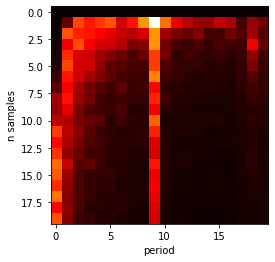

In [13]:
# DO THE SIM
# get our samples and plot var for diff ns and ts
NRANGE = 100
ninc = 5
TRANGE = 100
tinc = 5
SIGNAL = m1
M = 100

mom = 2

# ugly way of applying these funcs across the ranges im so sorry
a = []
for n in range(1,NRANGE,ninc):
    b = []
    print(n)
    for t in range(1,TRANGE,tinc):
        
        b.append(stats(m1,t,n,M,mom))
    a.append(np.array(b))
a = np.array(a)
        
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('period')
plt.ylabel('n samples')

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


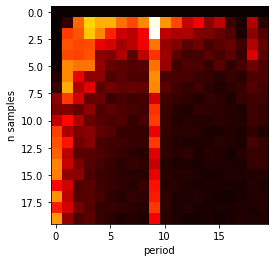

In [15]:
mom = 4

# ugly way of applying these funcs across the ranges im so sorry
a = []
for n in range(1,NRANGE,ninc):
    b = []
    print(n)
    for t in range(1,TRANGE,tinc):

        b.append(stats(m1,t,n,M,mom))
    a.append(np.array(b))
a = np.array(a)
        
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('period')
plt.ylabel('n samples')
plt.show()